In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from pyswarm import pso
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error, r2_score

import warnings
warnings.filterwarnings("ignore")

In [6]:
# Read the CSV file
car_price_df = pd.read_csv('car_price.csv')
car_price_df = car_price_df.drop(columns=['Unnamed: 0']).reset_index(drop=True)
car_price_df

,car_name,car_prices_in_rupee,kms_driven,fuel_type,transmission,ownership,manufacture,engine,Seats
0,Jeep Compass 2.0 Longitude Option BSIV,10.03 Lakh,"86,226 kms",Diesel,Manual,1st Owner,2017,1956 cc,5 Seats
1,Renault Duster RXZ Turbo CVT,12.83 Lakh,"13,248 kms",Petrol,Automatic,1st Owner,2021,1330 cc,5 Seats
2,Toyota Camry 2.5 G,16.40 Lakh,"60,343 kms",Petrol,Automatic,1st Owner,2016,2494 cc,5 Seats
3,Honda Jazz VX CVT,7.77 Lakh,"26,696 kms",Petrol,Automatic,1st Owner,2018,1199 cc,5 Seats
4,Volkswagen Polo 1.2 MPI Highline,5.15 Lakh,"69,414 kms",Petrol,Manual,1st Owner,2016,1199 cc,5 Seats
...,...,...,...,...,...,...,...,...,...
5507,BMW X1 sDrive 20d xLine,28.90 Lakh,"45,000 kms",Diesel,Automatic,1st Owner,2018,2995 cc,7 Seats
5508,BMW M Series M4 Coupe,64.90 Lakh,"29,000 kms",Petrol,Automatic,2nd Owner,2015,1968 cc,5 Seats
5509,Jaguar XF 2.2 Litre Luxury,13.75 Lakh,"90,000 kms",Diesel,Automatic,2nd Owner,2013,2755 cc,5 Seats
5510,BMW 7 Series 730Ld,29.90 Lakh,"79,000 kms",Diesel,Automatic,3rd Owner,2015,2967 cc,6 Seats


### Data Clearing & Preparation

In [7]:
# Function to convert price to numeric value
def convert_price(price_str):
    if ' Lakh' in price_str:
        return float(price_str.replace(' Lakh', '')) * 100000
    elif ' Crore' in price_str:
        return float(price_str.replace(' Crore', '')) * 10000000
    else:
        return None

# Apply the conversion function to the 'car_prices_in_rupee' column
car_price_df['car_prices_in_rupee'] = car_price_df['car_prices_in_rupee'].apply(convert_price)

# Convert 'kms_driven' to numeric (remove ' kms' and commas)
car_price_df['kms_driven'] = car_price_df['kms_driven'].str.replace(' kms', '').str.replace(',', '').astype(int)

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Apply LabelEncoder to categorical columns
categorical_columns = ['fuel_type', 'transmission', 'ownership', 'Seats']
for col in categorical_columns:
    car_price_df[col] = label_encoder.fit_transform(car_price_df[col])

# Convert 'engine' column to numeric (remove ' cc')
car_price_df['engine'] = car_price_df['engine'].str.replace(' cc', '').astype(int)

# Check the data types 
car_price_df.dtypes

car_name                object
car_prices_in_rupee    float64
kms_driven               int64
fuel_type                int64
transmission             int64
ownership                int64
manufacture              int64
engine                   int64
Seats                    int64
dtype: object

In [24]:
# Check the data in the first few rows after cleaning
car_price_df

,car_name,car_prices_in_rupee,kms_driven,fuel_type,transmission,ownership,manufacture,engine,Seats,car_age,engine_per_seat
0,Jeep Compass 2.0 Longitude Option BSIV,1003000.0,86226,1,1,1,2017,1956,2,5,978.00
1,Renault Duster RXZ Turbo CVT,1283000.0,13248,4,0,1,2021,1330,2,1,665.00
2,Toyota Camry 2.5 G,1640000.0,60343,4,0,1,2016,2494,2,6,1247.00
3,Honda Jazz VX CVT,777000.0,26696,4,0,1,2018,1199,2,4,599.50
4,Volkswagen Polo 1.2 MPI Highline,515000.0,69414,4,1,1,2016,1199,2,6,599.50
...,...,...,...,...,...,...,...,...,...,...,...
5507,BMW X1 sDrive 20d xLine,2890000.0,45000,1,0,1,2018,2995,4,4,748.75
5508,BMW M Series M4 Coupe,6490000.0,29000,4,0,2,2015,1968,2,7,984.00
5509,Jaguar XF 2.2 Litre Luxury,1375000.0,90000,1,0,2,2013,2755,2,9,1377.50
5510,BMW 7 Series 730Ld,2990000.0,79000,1,0,3,2015,2967,3,7,989.00


In [9]:
# Check the missing value
car_price_df.isnull().sum()

car_name                 0
car_prices_in_rupee    123
kms_driven               0
fuel_type                0
transmission             0
ownership                0
manufacture              0
engine                   0
Seats                    0
dtype: int64

In [10]:
# Drop rows with missing values
car_price_df = car_price_df.dropna()
car_price_df.isnull().sum()

car_name               0
car_prices_in_rupee    0
kms_driven             0
fuel_type              0
transmission           0
ownership              0
manufacture            0
engine                 0
Seats                  0
dtype: int64

In [11]:
car_price_df

,car_name,car_prices_in_rupee,kms_driven,fuel_type,transmission,ownership,manufacture,engine,Seats
0,Jeep Compass 2.0 Longitude Option BSIV,1003000.0,86226,1,1,1,2017,1956,2
1,Renault Duster RXZ Turbo CVT,1283000.0,13248,4,0,1,2021,1330,2
2,Toyota Camry 2.5 G,1640000.0,60343,4,0,1,2016,2494,2
3,Honda Jazz VX CVT,777000.0,26696,4,0,1,2018,1199,2
4,Volkswagen Polo 1.2 MPI Highline,515000.0,69414,4,1,1,2016,1199,2
...,...,...,...,...,...,...,...,...,...
5507,BMW X1 sDrive 20d xLine,2890000.0,45000,1,0,1,2018,2995,4
5508,BMW M Series M4 Coupe,6490000.0,29000,4,0,2,2015,1968,2
5509,Jaguar XF 2.2 Litre Luxury,1375000.0,90000,1,0,2,2013,2755,2
5510,BMW 7 Series 730Ld,2990000.0,79000,1,0,3,2015,2967,3


### Exploratory Data Analysis ###
Check the distribution of data in each feature.
View relationships between features with the price of the car


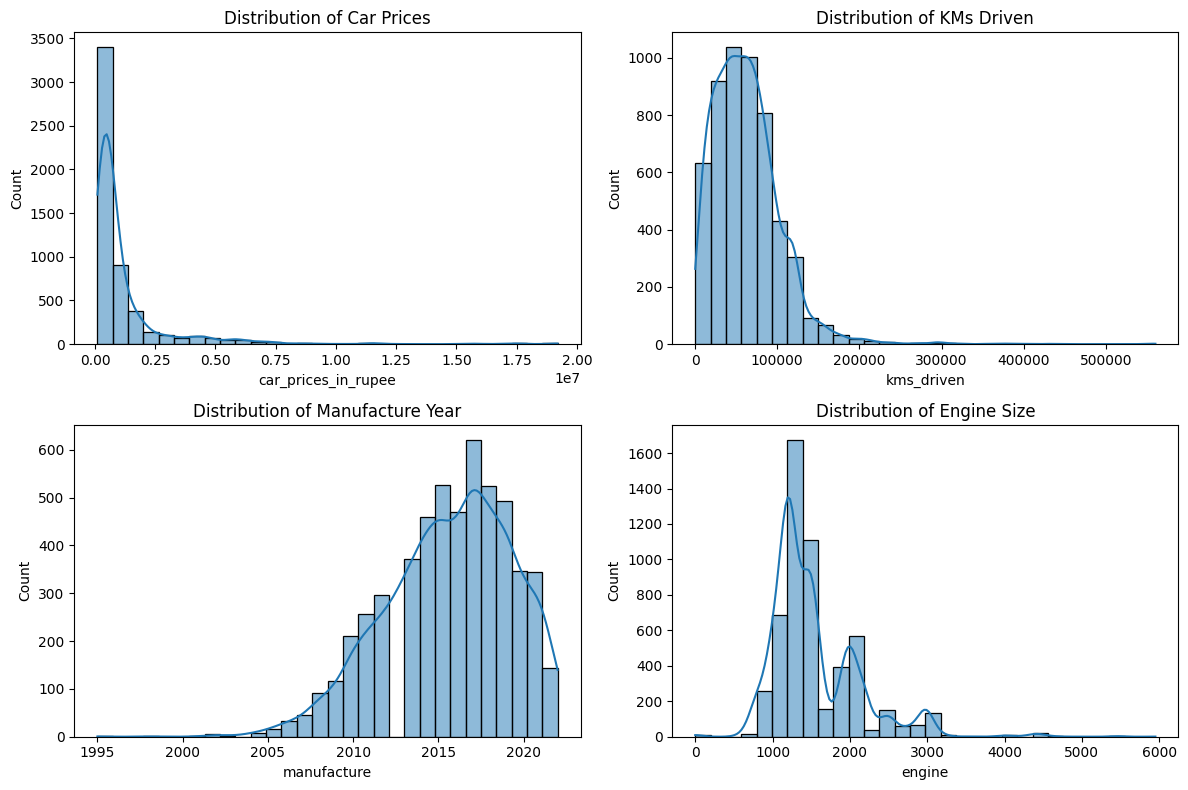

In [32]:
### Exploratory Data Analysis ###
# Check the distribution of data in each feature.
# View relationships between features with the price of the car

# Set up the matplotlib figure
plt.figure(figsize=(12, 8))

# Plot the distribution of car prices
plt.subplot(2, 2, 1)
sns.histplot(car_price_df['car_prices_in_rupee'], bins=30, kde=True)
plt.title('Distribution of Car Prices')

# Plot the distribution of kms driven
plt.subplot(2, 2, 2)
sns.histplot(car_price_df['kms_driven'], bins=30, kde=True)
plt.title('Distribution of KMs Driven')

# Plot the distribution of manufacture year
plt.subplot(2, 2, 3)
sns.histplot(car_price_df['manufacture'], bins=30, kde=True)
plt.title('Distribution of Manufacture Year')

# Plot the distribution of engine size
plt.subplot(2, 2, 4)
sns.histplot(car_price_df['engine'], bins=30, kde=True)
plt.title('Distribution of Engine Size')


plt.tight_layout()
plt.show()

From the graph obtained:
1. Distribution of Car Prices: The prices of most cars are in the range below 2 million rupees. There is quite a high dispersion in prices.
2. Distribution of KMs Driven: The distance driven is mostly under 100,000 kilometers.
3. Distribution of Manufacture Year: Most production years are after 2010.
4. Distribution of Engine Size: Most engine sizes are below 2000 cc.

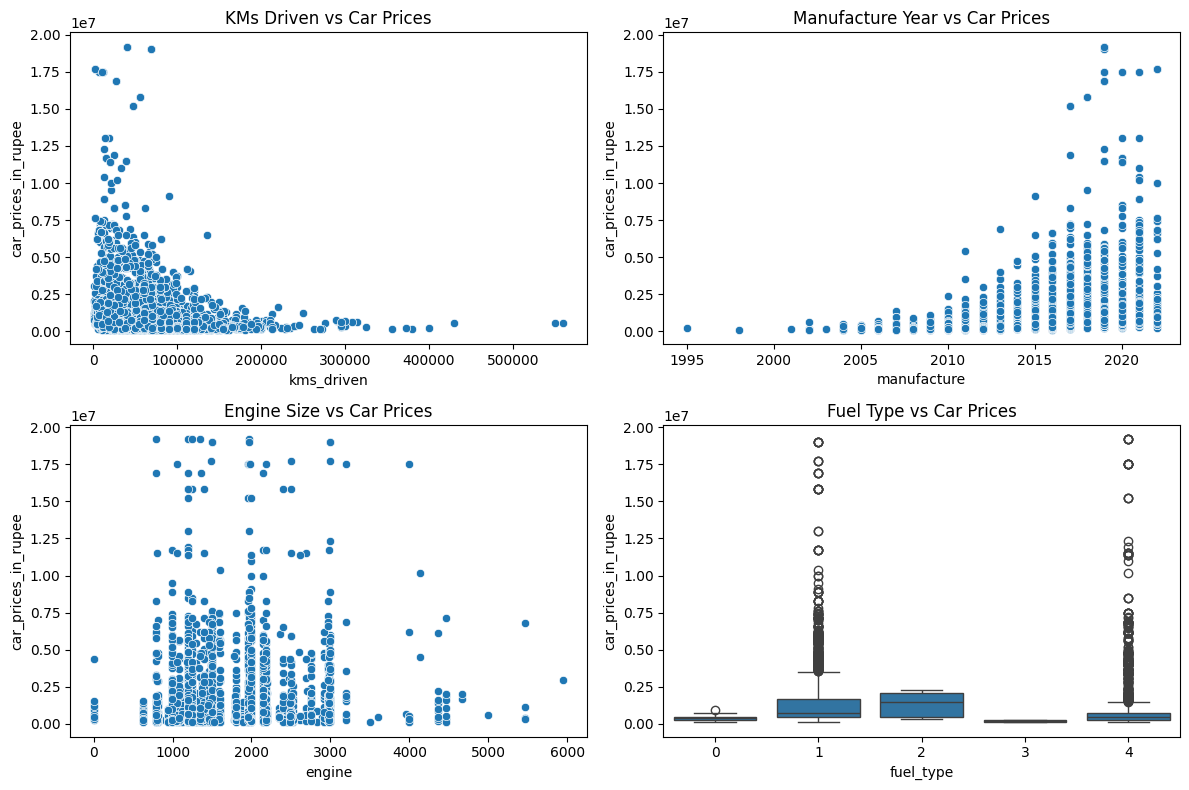

In [31]:
# Set up the matplotlib figure
plt.figure(figsize=(12, 8))

# Scatter plot of kms driven vs car prices
plt.subplot(2, 2, 1)
sns.scatterplot(x='kms_driven', y='car_prices_in_rupee', data=car_price_df)
plt.title('KMs Driven vs Car Prices')

# Scatter plot of manufacture year vs car prices
plt.subplot(2, 2, 2)
sns.scatterplot(x='manufacture', y='car_prices_in_rupee', data=car_price_df)
plt.title('Manufacture Year vs Car Prices')

# Scatter plot of engine size vs car prices
plt.subplot(2, 2, 3)
sns.scatterplot(x='engine', y='car_prices_in_rupee', data=car_price_df)
plt.title('Engine Size vs Car Prices')

# Box plot of fuel type vs car prices
plt.subplot(2, 2, 4)
sns.boxplot(x='fuel_type', y='car_prices_in_rupee', data=car_price_df)
plt.title('Fuel Type vs Car Prices')

plt.tight_layout()
plt.show()

From the graph obtained:
1. KMs Driven vs Car Prices: There is a tendency for the price of a car to decrease as the distance driven increases. But there is quite a spread of information.
2. Manufacture Year vs Car Prices: The price of a car will likely be higher the year it was manufactured.
3. Engine Size vs Car Prices: The price of a car will likely increase as the engine size increases.
4. Fuel Type vs Car Prices: Fuel type affects the price of a car. The prices of diesel and gasoline cars are different.

### Feature Engineering 
We will create new features. That may help in making predictions.
1. Combining year of manufacture and engine size is a new feature.
2. Creating additional features from existing data.

In [14]:
# Create a new feature: car age (data frame last updated 2022)
car_price_df['car_age'] = 2022 - car_price_df['manufacture']

# Create a new feature: engine per seat (engine size divided by number of seats)
car_price_df['engine_per_seat'] = car_price_df['engine'] / car_price_df['Seats']

# Check the first few rows with new features
car_price_df[['car_age', 'engine_per_seat']].head()

,car_age,engine_per_seat
0,5,978.0
1,1,665.0
2,6,1247.0
3,4,599.5
4,6,599.5


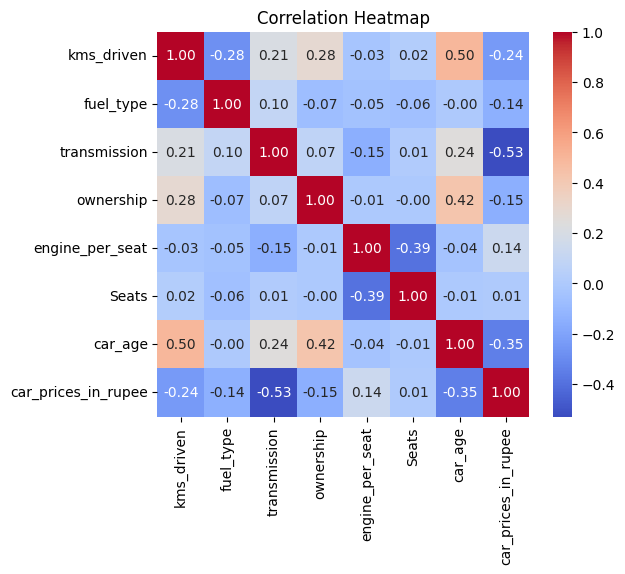

In [15]:
# Select features and target
features = ['kms_driven', 'fuel_type', 'transmission', 'ownership', 'engine_per_seat', 'Seats', 'car_age', 'car_prices_in_rupee']
df_selected = car_price_df[features]

# Calculate the correlation matrix
correlation_matrix = df_selected.corr()

# Plot the heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

### Modeling 
The next step is to create a model using all our features.

We will use the following features: kms_driven, fuel_type, transmission, ownership, engine, Seats, car_age, engine_per_seat

In [16]:
# Identify infinite values and replace them with NaN
car_price_df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Remove rows with NaN values
car_price_df.dropna(inplace=True)

# Check if there are any infinite values left
car_price_df_cleaned = car_price_df.isin([np.inf, -np.inf]).sum()

In [25]:
# Select features and target
features = ['car_name', 'kms_driven', 'fuel_type', 'transmission', 'ownership', 'engine_per_seat', 'Seats', 'car_age']
target = 'car_prices_in_rupee'

# Preprocess features
X = car_price_df[features]
y = car_price_df[target]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=22)

# Define the preprocessing steps for numerical and categorical features
numerical_features = ['kms_driven', 'ownership', 'engine_per_seat', 'Seats', 'car_age']
categorical_features = ['car_name', 'fuel_type', 'transmission']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
    ]
)

#### Linear Regression Model

Root Mean Squared Error (RMSE): 647364.4948600739
Mean Absolute Error (MAE): 276688.1366177148
Mean Absolute Percentage Error (MAPE): 0.4450142222136333
R^2 Score: 0.8853435107258985


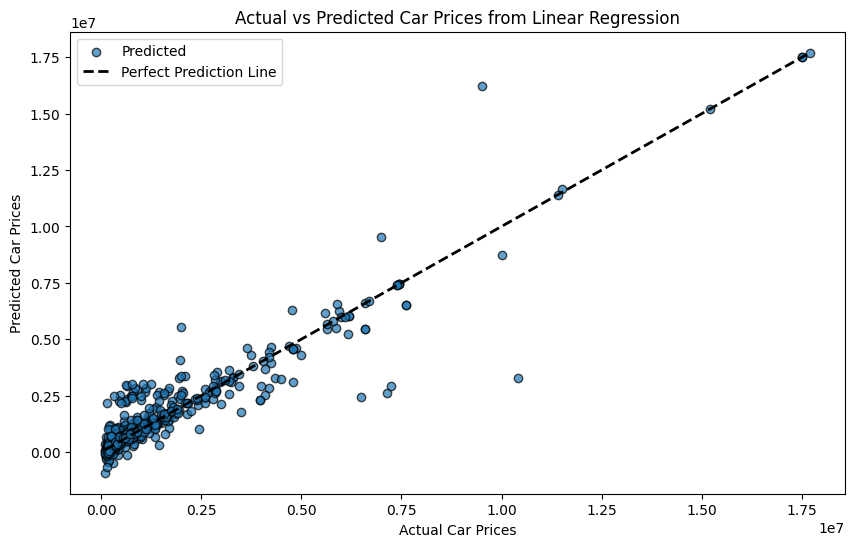

In [18]:
# Create a pipeline with preprocessing and Linear Regression
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Calculate evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = mean_absolute_percentage_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

# Print the evaluation metrics
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Absolute Percentage Error (MAPE): {mape}')
print(f'R^2 Score: {r2}')

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, edgecolor='k', alpha=0.7, label='Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Perfect Prediction Line')
plt.xlabel('Actual Car Prices')
plt.ylabel('Predicted Car Prices')
plt.title('Actual vs Predicted Car Prices from Linear Regression')
plt.legend()
plt.show()


##### Use Particle Swarm Optimization(PSO) for Hyperparameter tuning the XGBoost model.

In [35]:
# Objective function for PSO
def objective_function(params):
    n_estimators, max_depth, learning_rate, subsample = params
    n_estimators = int(n_estimators)
    max_depth = int(max_depth)
    learning_rate = float(learning_rate)
    subsample = float(subsample)

    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', XGBRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            learning_rate=learning_rate,
            subsample=subsample,
            random_state=42))
    ])

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    return rmse

# Define the parameter bounds
lb = [100, 6, 0.001, 0.5]  # Lower bounds for n_estimators, max_depth, learning_rate, subsample
ub = [600, 15, 1, 1.0]  # Upper bounds for n_estimators, max_depth, learning_rate, subsample

# Perform PSO
best_params, best_score = pso(objective_function, lb, ub, swarmsize=20, maxiter=50)

print(f'Best Parameters: {best_params}')
print(f'Best RMSE: {best_score}')

Stopping search: maximum iterations reached --> 50
Best Parameters: [4.39542110e+02 1.06375497e+01 2.71092281e-01 5.83277867e-01]
Best RMSE: 549179.4585616741


#### XGBoost Model

Root Mean Squared Error (RMSE): 617301.5234806457
Mean Absolute Error (MAE): 270138.00781552156
Mean Absolute Percentage Error (MAPE): 0.30426370602203984
R^2 Score: 0.8957453140814744


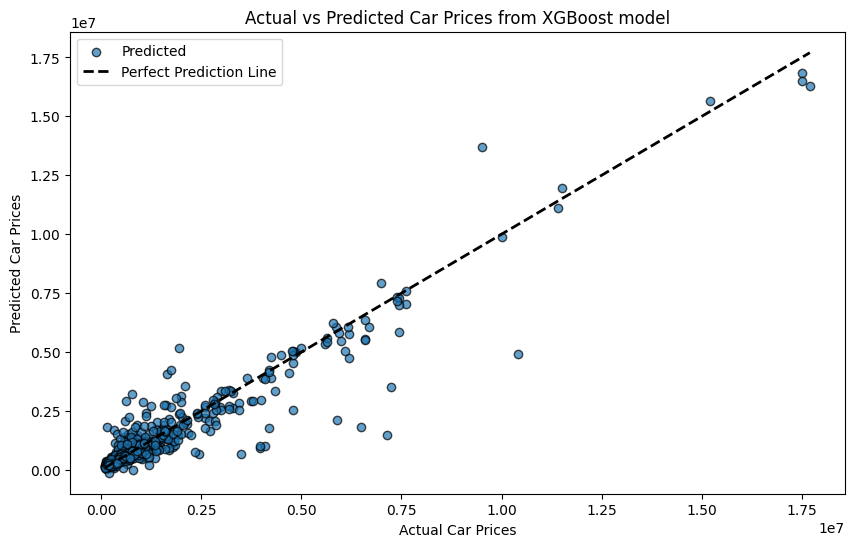

In [26]:
# Parameters for XGBoost
n_estimators = 440
max_depth = 11
learning_rate = 0.27
subsample = 0.58

# Create a pipeline with preprocessing and XGBoost
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        subsample=subsample,
        random_state=42))
])

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Calculate evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = mean_absolute_percentage_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

# Print the evaluation metrics
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Absolute Percentage Error (MAPE): {mape}')
print(f'R^2 Score: {r2}')

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, edgecolor='k', alpha=0.7, label='Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Perfect Prediction Line')
plt.xlabel('Actual Car Prices')
plt.ylabel('Predicted Car Prices')
plt.title('Actual vs Predicted Car Prices from XGBoost model')
plt.legend()
plt.show()

### Conclusion
#####      Based on the experimental results, the XGBoost model exhibited lower RMSE, MAE, and MAPE values,
##### and a higher R² score compared to the Linear Regression model. Therefore, we will proceed with using 
##### XGBoost for prediction and API development.

In [27]:
import pickle
# save model to .pkl
with open('xgboost_model.pkl', 'wb') as file:
    pickle.dump(model, file)

Candidate: Natdanai Sriapai, Phone: 0640911178